In [27]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sm

import warnings
import xgboost as xgb

from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from tqdm import tqdm

from collections import OrderedDict


warnings.filterwarnings("ignore")

%matplotlib inline

In [28]:
train_df = pd.read_csv("mai-ml-hw-models/Train.csv")
test_df = pd.read_csv("mai-ml-hw-models/Test.csv")
sample_df = pd.read_csv("mai-ml-hw-models/SampleSubmission.csv")

indexes = test_df.id

test_df = test_df.drop(['id'], axis = 1)
train_df = train_df.drop(['id'], axis = 1)
train_df[train_df.floor > 5].head(5)

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
7,2011-01-01,410,NaN,7,33,1,0,NaN,0.0,2,...,0,0,0,0,0,0,0,0,0,2736000
8,2011-01-01,196,NaN,6,54,2,1,25.0,NaN,2,...,0,0,0,0,0,0,0,0,0,9047000
11,2011-01-01,214,NaN,8,34,1,0,30.0,NaN,0,...,0,0,0,0,0,0,0,0,0,3035000
12,2011-01-01,259,NaN,11,58,2,0,15.0,1.0,2,...,0,1,0,0,0,0,0,0,0,6652000
16,2011-01-01,601,1.0,10,34,1,1,20.0,NaN,1,...,0,0,0,0,0,0,0,0,0,5265000


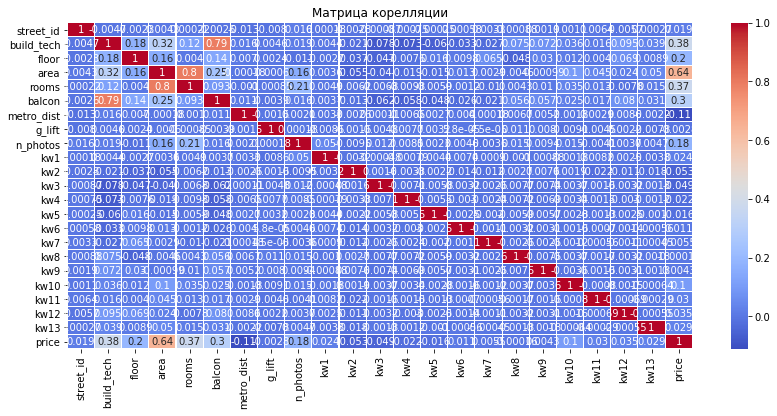

In [29]:
fi = plt.figure(figsize= (14, 6))
ax1 = fi.add_subplot()
ax1.set_title('Матрица корелляции')
sns.heatmap(train_df[train_df.build_tech.notna()].corr(), annot=True, cmap = "coolwarm", linewidth = 0.1, ax = ax1)

In [30]:
train_df.area.unique()

array([ 67,  45,  61,  51,  60,  34,  36,  33,  54,  43,  31,  58,  32,
        35,  50,  44,  48,  59,  52,  47, 125,  88, 168,  65, 167,  46,
        71,  63,  55,  57,  90,  41,  62,  38,  75,  70,  40, 183,  56,
       166,  39,  42,  98,  74,  53,  37,  29,  73, 104, 142,  66,  72,
        95,  91,  49,  64,  87, 105,  89,  30, 110,  86, 163,  97,  99,
        69, 123,  76, 112, 124, 109,  93, 143,  68,  77, 173, 153, 185,
       181, 215, 127, 145,  92, 102, 184, 154, 101,  94, 108, 111, 152,
       182, 144, 174,  96, 107, 103, 175, 165, 126, 216, 164, 155, 100,
       217, 156, 171, 141, 161, 169, 213, 162])

In [31]:
test_df.street_id.unique()

array([522, 577, 558, 445, 365, 661, 153, 507, 659, 436, 198, 514, 518,
       202, 406, 334,  94, 358, 461, 427, 126, 296, 131, 337, 488, 506,
       399,  70, 517, 520, 120,  79, 585, 172, 372,  68, 103, 584, 319,
       147, 351, 541, 550, 586, 291,  72,  93, 238, 579, 315,   3, 247,
       503, 303, 183, 602, 112, 525, 660, 195,  96, 276, 237, 343, 141,
       470, 444, 396, 441, 643,  80, 533, 598, 222, 519, 622, 455,  81,
       648, 145, 359, 528, 594,  42, 644, 486, 140,   4, 653, 114, 105,
       346, 316, 314, 106, 633,  92,  58, 338,  54, 477, 333, 310, 641,
       234, 537, 362, 391, 127, 654, 574, 459, 341,  38, 243, 299, 305,
        22, 616, 129, 619,  69, 617, 452, 192, 449, 244, 163, 556, 472,
       650,  90,  85, 167, 270, 193, 228, 352, 330,  24, 175, 293, 416,
       421, 279, 267, 454, 286, 388, 249, 150, 656,  17, 397,  83, 526,
       581, 297, 613,  62, 260,  59, 300, 405, 235, 419, 647, 471, 453,
       492,  61, 402, 642, 143, 559, 283,   5, 377, 166, 539, 63

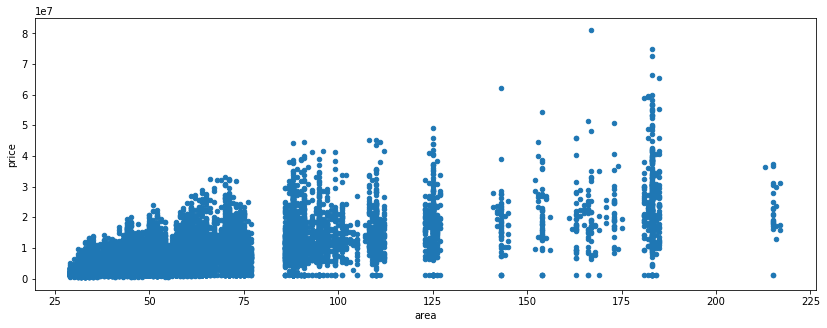

In [32]:
# train_df.build_tech[train_df.balcon != 0] = train_df.balcon[train_df.balcon != 0]
# test_df.build_tech[test_df.balcon != 0] = test_df.balcon[test_df.balcon != 0]

# print(train_df[train_df.build_tech.isnull()].shape[0])

# train_df.build_tech[train_df.build_tech.isnull()] = \
# train_df.build_tech[train_df.balcon == 0 & train_df.build_tech.notnull()].mean()

# print(train_df[train_df.build_tech.isnull()].shape[0])

# test_df.build_tech[test_df.build_tech.isnull()] = \
# test_df.build_tech[test_df.balcon == 0 & test_df.build_tech.notnull()].mean()
train_df.plot.scatter(x = 'area', y = 'price', figsize = (14, 5))

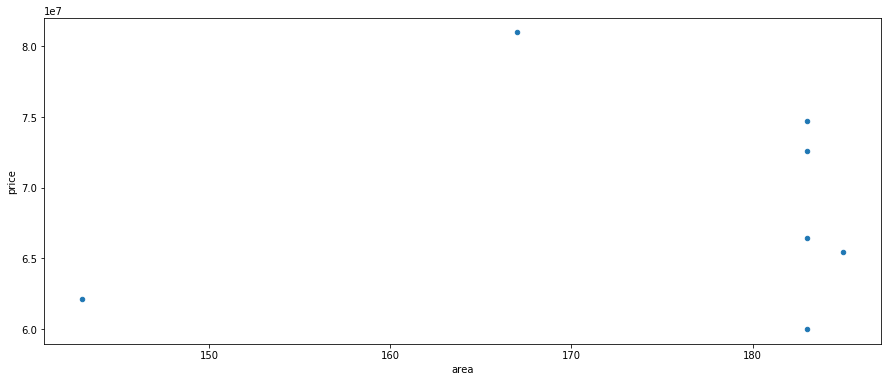

In [33]:
train_df[train_df.price > 60000000].plot.scatter(x = 'area', y = 'price', figsize = (15, 6))

In [34]:
train_df.price.max()

80979000

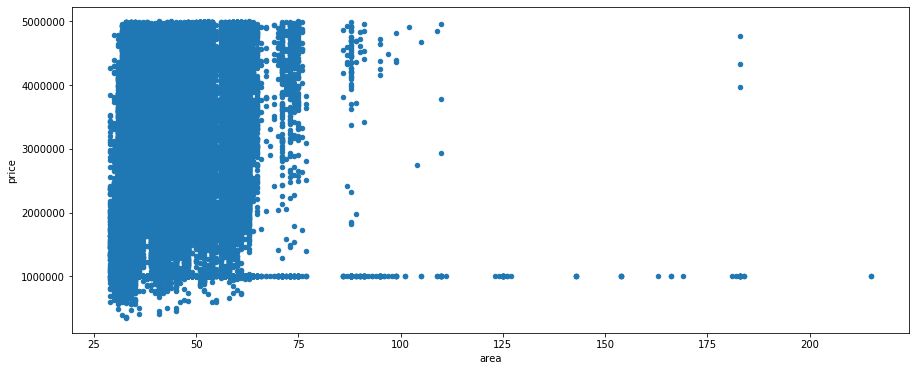

In [35]:
train_df[train_df.price < 5000000].plot.scatter(x = 'area', y = 'price', figsize = (15, 6))

In [36]:
train_df = train_df[train_df.price < 60000000] 
train_df = train_df[train_df.price > 550000]
#train_df = train_df[train_df.price > ]

In [37]:
train_df.price.min()

560000

In [38]:
# msk = train_df.metro_dist.isnull()
# msk3 = train_df.metro_dist.notnull()

# new_feature = train_df.metro_dist.copy()
# new_feature[msk] = 1.0
# new_feature[msk3] = 0.0
# train_df.metro_dist[msk] = train_df.metro_dist[msk3].mean()
# train_df['not_metro'] = new_feature

# msk = test_df.metro_dist.isnull()
# msk3 = test_df.metro_dist.notnull()
# new_feature = test_df.metro_dist.copy()
# new_feature[msk] = 1
# new_feature[msk3] = 0
# test_df.metro_dist[msk] = test_df.metro_dist[msk3].mean()
# test_df['not_metro'] = new_feature
train_df.head(10)


,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-01-01,511,1.0,5,67,2,1,NaN,1.0,1,...,0,0,0,0,0,0,0,0,0,18473000
1,2011-01-01,299,0.0,3,45,2,0,20.0,0.0,0,...,0,0,0,0,0,0,0,0,0,4157000
2,2011-01-01,217,NaN,1,61,3,1,10.0,1.0,1,...,0,0,0,0,0,0,0,0,0,4530000
3,2011-01-01,212,NaN,2,51,2,1,15.0,0.0,2,...,0,0,0,0,0,0,0,0,0,7981000
4,2011-01-01,160,1.0,3,60,3,1,25.0,0.0,1,...,0,0,0,0,0,0,0,0,0,11888000
5,2011-01-01,438,NaN,2,34,1,0,20.0,0.0,3,...,0,0,0,0,0,0,0,0,0,2357000
6,2011-01-01,404,0.0,3,36,1,0,15.0,NaN,1,...,0,0,0,0,0,0,0,0,0,3841000
7,2011-01-01,410,NaN,7,33,1,0,NaN,0.0,2,...,0,0,0,0,0,0,0,0,0,2736000
8,2011-01-01,196,NaN,6,54,2,1,25.0,NaN,2,...,0,0,0,0,0,0,0,0,0,9047000
9,2011-01-01,331,0.0,3,43,2,0,NaN,1.0,3,...,0,0,0,0,0,0,0,0,0,1577000


In [39]:
# new_feature = train_df[['kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', \
#                         'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']].sum(axis = 1)
# train_df['n_kw'] = new_feature

# new_feature = test_df[['kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', \
#                         'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']].sum(axis = 1)
# test_df['n_kw'] = new_feature

In [40]:
seria = train_df.date.str.split(pat = '-')
type(seria)
#train_df['year'] = seria.str[0]
train_df['mounth'] = seria.str[1]
# dataset['Gate'] = seria.str[0]
# dataset['Numeric'] = seria.str[1::]

seria = test_df.date.str.split(pat = '-')
type(seria)
# test_df['year'] = seria.str[0]
test_df['mounth'] = seria.str[1]

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
date          100000 non-null object
street_id     100000 non-null int64
build_tech    70088 non-null float64
floor         100000 non-null int64
area          100000 non-null int64
rooms         100000 non-null int64
balcon        100000 non-null int64
metro_dist    95084 non-null float64
g_lift        69805 non-null float64
n_photos      100000 non-null int64
kw1           100000 non-null int64
kw2           100000 non-null int64
kw3           100000 non-null int64
kw4           100000 non-null int64
kw5           100000 non-null int64
kw6           100000 non-null int64
kw7           100000 non-null int64
kw8           100000 non-null int64
kw9           100000 non-null int64
kw10          100000 non-null int64
kw11          100000 non-null int64
kw12          100000 non-null int64
kw13          100000 non-null int64
mounth        100000 non-null object
dtypes: float64(3), i

In [41]:
# new_feature = train_df.n_photos.copy()
# new_feature[train_df.n_photos < train_df.rooms] = 0
# new_feature[train_df.n_photos >= train_df.rooms] = 1
# train_df['rooms_with_photo'] = new_feature

# new_feature = test_df.n_photos.copy()
# new_feature[test_df.n_photos < test_df.rooms] = 0
# new_feature[test_df.n_photos >= test_df.rooms] = 1
# test_df['rooms_with_photo'] = new_feature
# test_df.head()

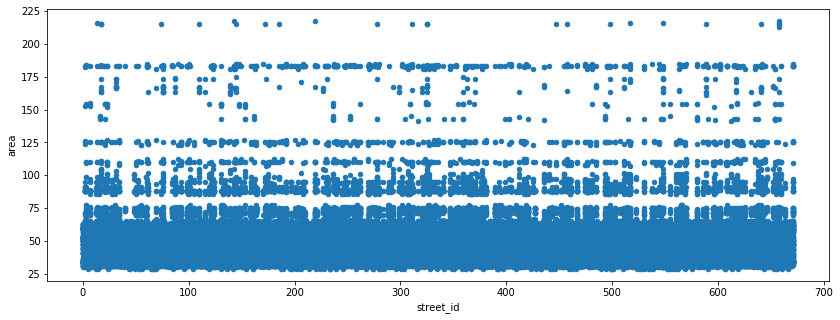

In [42]:
train_df.plot.scatter(x='street_id', y='area',figsize=(14,5))

In [43]:
OH_cols = ['date', 'mounth']

test_df['place'] = 1000 * test_df.area + test_df.street_id
train_df['place'] = 1000 * train_df.area + train_df.street_id

train2_df = train_df.copy()
test2_df = test_df.copy()
train2_df.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,mounth,place
0,2011-01-01,511,1.0,5,67,2,1,NaN,1.0,1,...,0,0,0,0,0,0,0,18473000,01,67511
1,2011-01-01,299,0.0,3,45,2,0,20.0,0.0,0,...,0,0,0,0,0,0,0,4157000,01,45299
2,2011-01-01,217,NaN,1,61,3,1,10.0,1.0,1,...,0,0,0,0,0,0,0,4530000,01,61217
3,2011-01-01,212,NaN,2,51,2,1,15.0,0.0,2,...,0,0,0,0,0,0,0,7981000,01,51212
4,2011-01-01,160,1.0,3,60,3,1,25.0,0.0,1,...,0,0,0,0,0,0,0,11888000,01,60160


In [44]:
full_df = pd.concat([train2_df, test2_df], axis = 0)

encoder = LabelEncoder()

for col in OH_cols:
    print(f"Encoding {col}")
    full_df[col] = encoder.fit_transform(full_df[col])

msk = full_df.g_lift.isnull()
msk2 = full_df.floor > 5
msk3 = full_df.g_lift.notnull()
full_df.g_lift[msk] = 0
full_df.g_lift[msk] = full_df.g_lift[msk3].mean()

msk = full_df.metro_dist.isnull()
msk3 = full_df.metro_dist.notnull()
new_feature = full_df.metro_dist.copy()
# new_feature[msk] = 1
# new_feature[msk3] = 0
full_df.metro_dist[msk] = full_df.metro_dist[msk3].mean()
full_df['not_metro'] = new_feature
# full_df.head(20)

full_df.build_tech[full_df.balcon != 0] = full_df.balcon[full_df.balcon != 0]
full_df.build_tech[full_df.build_tech.isnull()] = \
full_df.build_tech[full_df.balcon == 0 & full_df.build_tech.notnull()].mean()

#full_df['mean_md'] = full_df['area'].map(full_df.groupby('area')['metro_dist'].mean())

# full_df['max_area_p'] = train2_df.price.max()
# full_df['min_area_p'] = train2_df.price.min()
full_df['mean_area_p'] = train2_df.price.mean()

#full_df.max_area_p[full_df.area < 214] = full_df.area[full_df.area < 214].map(train2_df.groupby('area')['price'].max())
#full_df.min_area_p[full_df.area < 214] = full_df.area[full_df.area < 214].map(train2_df.groupby('area')['price'].min())
full_df.mean_area_p[full_df.area < 214] = full_df.area[full_df.area < 214].map(train2_df.groupby('area')['price'].mean())


#full_df['max_rooms_p'] = full_df['rooms'].map(train2_df.groupby('rooms')['price'].max())
#full_df['min_rooms_p'] = full_df['rooms'].map(train2_df.groupby('rooms')['price'].min())
full_df['mean_rooms_p'] = full_df['rooms'].map(train2_df.groupby('rooms')['price'].mean())

#full_df['mean_balcon_p'] = full_df['balcon'].map(train2_df.groupby('balcon')['price'].mean())

#full_df['mean_photo_p'] = full_df['n_photos'].map(train2_df.groupby('n_photos')['price'].mean())


full_df['mean_floor_p'] = full_df['floor'].map(train2_df.groupby('floor')['price'].mean())


train2_df = full_df[full_df.price.notnull()]

full_df['mean_mounth_p'] = full_df['mounth'].map(train2_df.groupby('mounth')['price'].mean())
#full_df['max_mounth_p'] = full_df['mounth'].map(train2_df.groupby('mounth')['price'].max())
#full_df['min_mounth_p'] = full_df['mounth'].map(train2_df.groupby('mounth')['price'].min())

train2_df = full_df[full_df.price.notnull()]

test2_df = full_df[full_df.price.isnull()]
test2_df.drop("price", axis = 1, inplace = True)


train2_df.drop("g_lift", axis = 1, inplace = True)
test2_df.drop("g_lift", axis = 1, inplace = True)

Encoding date
Encoding mounth


In [45]:
target_col = train2_df.price
train2_df.drop(['price'], axis = 1, inplace=True)

In [46]:
train2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 29 columns):
area             99980 non-null int64
balcon           99980 non-null int64
build_tech       99980 non-null float64
date             99980 non-null int64
floor            99980 non-null int64
kw1              99980 non-null int64
kw10             99980 non-null int64
kw11             99980 non-null int64
kw12             99980 non-null int64
kw13             99980 non-null int64
kw2              99980 non-null int64
kw3              99980 non-null int64
kw4              99980 non-null int64
kw5              99980 non-null int64
kw6              99980 non-null int64
kw7              99980 non-null int64
kw8              99980 non-null int64
kw9              99980 non-null int64
metro_dist       99980 non-null float64
mounth           99980 non-null int64
n_photos         99980 non-null int64
place            99980 non-null int64
rooms            99980 non-null int64
street_id    

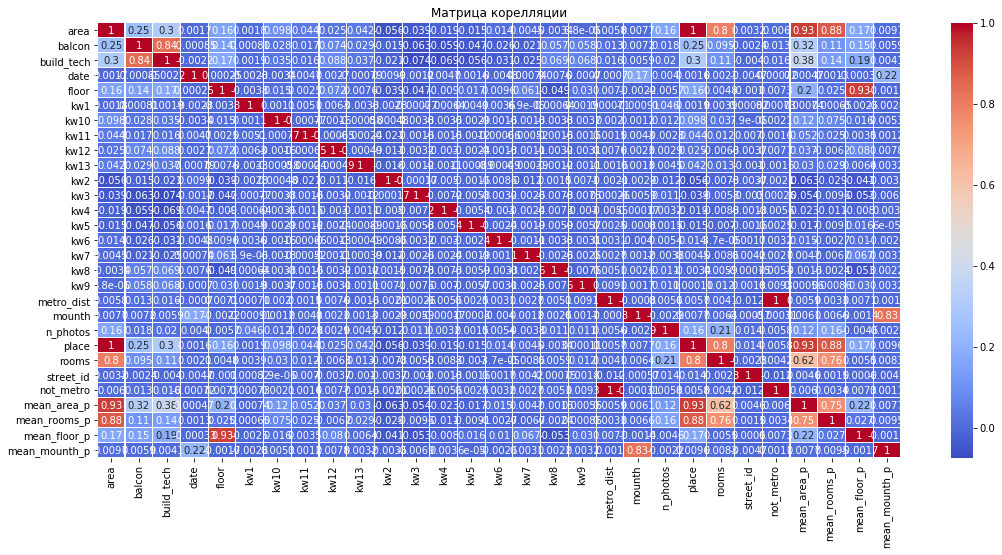

In [47]:
fi = plt.figure(figsize= (18, 8))
ax1 = fi.add_subplot()
ax1.set_title('Матрица корелляции')
sns.heatmap(train2_df.corr(), annot=True, cmap = "coolwarm", linewidth = 0.1, ax = ax1)

In [48]:
# NORMALISATION

train2_df = (train2_df - train2_df.min(axis = 0)) / (train2_df.max(axis = 0) - train2_df.min(axis = 0))
    
test2_df = (test2_df - test2_df.min(axis = 0)) / (test2_df.max(axis = 0) - test2_df.min(axis = 0))

In [49]:
n_est = 2000
mx_dpth = 7
# xgb_rgr = xgb.XGBRegressor(colsample_bytree=0.6, learning_rate=0.08, n_estimators=n_est, \
#                            reg_alpha=0.7, reg_lambda=0.3, subsample=0.7, seed=42, max_depth=mx_dpth)
# first_end = train2_df.shape[0] * 2 // 3
# X = train2_df.iloc[:first_end]
# X_t = train2_df.iloc[first_end:]
# Y = target_col[:first_end]
# Y_t = target_col[first_end:]
# xgb_rgr.fit(X, Y)
# Y_p = xgb_rgr.predict(X_t)
# print("MSE:", sm.mean_squared_error(Y_t, Y_p))


# # xgb_rgr = xgb.XGBRegressor(n_estimators=n_est, max_depth=mx_dpth)
# # xgb_rgr.fit(train2_df, target_col)
# # Y_test = xgb_rgr.predict(test2_df)

# # sample_df.head()
# steps = 10
# d = {}
# first_end = train2_df.shape[0] // 2
# dist = train2_df.shape[0] // (2 * steps)

# parameters = [0.025, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# for i in tqdm(range(steps)):
#     X = train2_df.iloc[:first_end + dist * i]
#     Y = target_col[:first_end + dist*i]
#     X_t = train2_df.iloc[first_end + dist * i : first_end + dist * (i+1)]
#     Y_t = target_col[first_end + dist * i : first_end + dist * (i+1)]
#     best = 1000000000000000000
    
#     for k in parameters:
#         #print("step =", i, "alfa =", k)
#         model = Lasso(alpha = k)
#         model.fit(X, Y)
#         Y_pred = model.predict(X_t)
#         num = sm.mean_squared_error(Y_t, Y_pred)
#         if num < best:
#             best = num
#             d[i] = k
#             print("New Mean Error:", best)
            
# d

In [50]:
def make_submission(ids, preds, output_path='submission.csv'):
    subm = pd.DataFrame()
    subm['id'] = ids
    subm['price'] = preds
    subm.to_csv(output_path, index=False)
    
model = xgb.XGBRegressor(colsample_bytree=0.6, learning_rate=0.08, n_estimators=n_est, \
                           reg_alpha=0.75, reg_lambda=0.45, subsample=0.75, seed=42, max_depth=mx_dpth)
model.fit(train2_df, target_col)
Y_test = model.predict(test2_df)
make_submission(indexes, Y_test)

[00:53:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [51]:
ans = pd.read_csv("submission.csv")
ans.head(15)

,id,price
0,100000,4228252.0
1,100001,4766436.5
2,100002,2624921.0
3,100003,2029393.2
4,100004,3671079.5
5,100005,1884067.8
6,100006,757241.6
7,100007,3883957.8
8,100008,4608103.5
9,100009,17536864.0


In [52]:
train2_df.head()

,area,balcon,build_tech,date,floor,kw1,kw10,kw11,kw12,kw13,...,mounth,n_photos,place,rooms,street_id,not_metro,mean_area_p,mean_rooms_p,mean_floor_p,mean_mounth_p
0,0.202128,0.5,0.5,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.204110,0.2,0.761550,NaN,0.223312,0.075005,0.042082,0.0
1,0.085106,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.086370,0.2,0.445604,0.666667,0.049051,0.075005,0.082659,0.0
2,0.170213,0.5,0.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.170747,0.4,0.323398,0.333333,0.112927,0.124952,0.000000,0.0
3,0.117021,0.5,0.5,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.2,0.117713,0.2,0.315946,0.500000,0.082422,0.075005,0.076705,0.0
4,0.164894,0.5,0.5,0.0,0.083333,1.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.165144,0.4,0.238450,0.833333,0.109974,0.124952,0.082659,0.0
